In [8]:
import re
import os
import numpy as np
# Directorio donde están los archivos
directorio = os.path.join("..", "data", "H2", "data_h2_pw", "3x3_aperiodic", "0covo")

# Expresión regular para buscar la línea con la energía total
patron_energia = r'Total PSPW energy\s*:\s*(-?\d+\.\d+E[+-]\d+)'

# Listas para almacenar distancias y energías
distancias = []
energias = []

# Verificar si el directorio existe
if not os.path.exists(directorio):
    print(f"El directorio {directorio} no existe. Verifica la ruta.")
    exit()

# Buscar todos los archivos en el directorio
archivos = os.listdir(directorio)

# Procesar cada archivo
for archivo in archivos:
    # Filtrar solo archivos que terminen en .out y comiencen con H2-
    if not (archivo.endswith('.out') and archivo.startswith('H2-')):
        continue

    # Extraer la distancia del nombre del archivo (por ejemplo, H2-1.0.out -> 1.0)
    nombre = os.path.basename(archivo)
    try:
        distancia = float(nombre.replace('H2-', '').replace('.out', ''))
        print(f"Procesando archivo: {nombre}, Distancia: {distancia}")  # Para depurar
    except ValueError:
        print(f'No se pudo extraer la distancia de {nombre}. Saltando...')
        continue

    # Construir la ruta completa del archivo
    ruta_archivo = os.path.join(directorio, archivo)

    # Leer el archivo y buscar la energía
    try:
        with open(ruta_archivo, 'r') as f:
            for linea in f:
                coincidencia = re.search(patron_energia, linea)
                if coincidencia:
                    energia = float(coincidencia.group(1))
                    distancias.append(distancia)
                    energias.append(energia)
                    print(f'Archivo: {nombre}, Distancia: {distancia}, Energía: {energia} Hartree')
                    break
            else:
                print(f'No se encontró la energía en {nombre}.')
    except FileNotFoundError:
        print(f'El archivo {ruta_archivo} no se encuentra.')
    except Exception as e:
        print(f'Error procesando {nombre}: {e}')
distancias = np.array(distancias)
energias =  np.array(energias)
sorted_indices = np.argsort(distancias)
distancias = distancias[sorted_indices]
energias = energias[sorted_indices]
# Imprimir el array con todas las energías
print('\nResultados finales:')
print('Distancias:', distancias)
print('Energías:', energias)

Procesando archivo: H2-1.0.out, Distancia: 1.0
Archivo: H2-1.0.out, Distancia: 1.0, Energía: -1.102164433 Hartree
Procesando archivo: H2-0.7.out, Distancia: 0.7
Archivo: H2-0.7.out, Distancia: 0.7, Energía: -1.137135966 Hartree
Procesando archivo: H2-0.9.out, Distancia: 0.9
Archivo: H2-0.9.out, Distancia: 0.9, Energía: -1.11942164 Hartree
Procesando archivo: H2-3.5.out, Distancia: 3.5
Archivo: H2-3.5.out, Distancia: 3.5, Energía: -0.8091026796 Hartree
Procesando archivo: H2-6.0.out, Distancia: 6.0
Archivo: H2-6.0.out, Distancia: 6.0, Energía: -0.7641059992 Hartree
Procesando archivo: H2-2.0.out, Distancia: 2.0
Archivo: H2-2.0.out, Distancia: 2.0, Energía: -0.9259375833 Hartree
Procesando archivo: H2-2.5.out, Distancia: 2.5
Archivo: H2-2.5.out, Distancia: 2.5, Energía: -0.8718278715 Hartree
Procesando archivo: H2-3.0.out, Distancia: 3.0
Archivo: H2-3.0.out, Distancia: 3.0, Energía: -0.8340345079 Hartree
Procesando archivo: H2-5.0.out, Distancia: 5.0
Archivo: H2-5.0.out, Distancia: 5.0, 

In [13]:
import numpy as np
import json
import slowquant.SlowQuant as sq
from slowquant.unitary_coupled_cluster.ucc_wavefunction import WaveFunctionUCC
import matplotlib.pyplot as plt
import pyscf
from pyscf import mcscf, ao2mo, fci
#ccpvtz, ccpvqz

geometries = ["""H 0.0 0.0 -0.3; H 0.0 0.0 0.3;""", 
             """H 0.0 0.0 -0.35; H 0.0 0.0 0.35;""",
             """H 0.0 0.0 -0.4; H 0.0 0.0 0.4;""",
             """H 0.0 0.0 -0.45; H 0.0 0.0 0.45;""",
             """H 0.0 0.0 -0.5; H 0.0 0.0 0.5;""",
             """H 0.0 0.0 -0.75; H 0.0 0.0 0.75;""",
             """H 0.0 0.0 -1.0; H 0.0 0.0 1.0;""",
             """H 0.0 0.0 -1.25; H 0.0 0.0 1.25;""",
             """H 0.0 0.0 -1.5; H 0.0 0.0 1.5;""",
             """H 0.0 0.0 -1.75; H 0.0 0.0 1.75;""",
             """H 0.0 0.0 -2.0; H 0.0 0.0 2.0;""",
             """H 0.0 0.0 -2.25; H 0.0 0.0 2.25;""",
             """H 0.0 0.0 -2.5; H 0.0 0.0 2.5;""",
             """H 0.0 0.0 -3.0; H 0.0 0.0 3.0;""",]#Angstrom

results_H2 = []

basis = "aug-cc-pvtz"
cas = (2, 10) # active space
unit = "angstrom"  #angstrom, bohr

for i, geometry in enumerate(geometries):
    print(f"\nProcessing geometry {i+1}:")
    print(geometry)
    #### SlowQuant
    SQobj = sq.SlowQuant()
    SQobj.set_molecule(geometry, distance_unit=unit)
    SQobj.set_basis_set(basis)

    #### PySCF
    mol = pyscf.M(atom = geometry, basis = basis, unit = unit)
    mf = mol.RHF().run()

    energy_HF = mf.e_tot

    #### HF 
    mo_coeffs = mf.mo_coeff

    #### get the integrals in the AO basis
    hcore_ao = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc')
    eri_4fold_ao = mol.intor('int2e_sph')

    # OO-UCCSD
    WF = WaveFunctionUCC(
    num_elec=SQobj.molecule.number_electrons,
    cas=cas,
    mo_coeffs=mo_coeffs,
    h_ao=hcore_ao,
    g_ao=eri_4fold_ao,
    excitations="SD",
    include_active_kappa=True,
    )
   
    WF.run_wf_optimization_1step(
    		optimizer_name="SLSQP", 
    		tol = 1e-7,
    		orbital_optimization=False)
   
    energy_uccsd = WF.energy_elec + mol.energy_nuc()

    fcisolver = fci.FCI(mf)
    
    energy_fci, fci_vector = fcisolver.kernel()

    norb_fci = fcisolver.norb
    print(f'Number of orbitals used in FCI: {norb_fci}')
    print(f"Hartree-Fock energy for geometry {i+1} = {energy_HF}")
    print(f"UCCSD energy for geometry {i+1} = {energy_uccsd}")
    print(f"FCI energy for geometry {i+1} = {energy_fci}")
  
    results_H2.append({
        'geometry': geometry,
        'energy Hartree-Fock': energy_HF,
        'energy uccsd': energy_uccsd,
        'energy fci': energy_fci,
        'nuclear_repulsion': mol.energy_nuc(),
        'electronic_energy': WF.energy_elec
    })

with open('results_pvqz_H2.json', 'w') as f:
    json.dump(results_H2, f, indent=4)  
    




Processing geometry 1:
H 0.0 0.0 -0.3; H 0.0 0.0 0.3;
converged SCF energy = -1.11548623703127
### Parameters information:
### Number kappa: 0
### Number theta1: 9
### Number theta2: 45
### Number theta3: 0
### Number theta4: 0
### Number theta5: 0
### Number theta6: 0
### Total parameters: 54

Iteration # | Iteration time [s] | Electronic energy [Hartree]
--------     1      |         1.47       |     -1.9853523521939800    
--------     2      |         1.59       |     -2.0002199664922555    
--------     3      |         1.58       |     -2.0003204808248349    
--------     4      |         1.55       |     -2.0003413924768738    
--------     5      |         1.63       |     -2.0003431630316957    
--------     6      |         0.98       |     -2.0003434252174932    
Number of orbitals used in FCI: 46
Hartree-Fock energy for geometry 1 = -1.1154862370312724
UCCSD energy for geometry 1 = -1.1183814070174931
FCI energy for geometry 1 = -1.1537619571547444

Processing geometry 2:


In [19]:
import os
from qiskit_nwchem_driver.nwchem2yaml import extract_fields
from qiskit_nwchem_driver import nwchem_driver
import yaml
from pyscf import fci
import matplotlib.pyplot as plt
import numpy as np

covos = [1,2,4,8,10,12,18,'no_']

for covo in covos:
    print('{} COVOs'.format(covo))
    # we start by defining the paths to the files
    data_dir_nwchem = os.path.join("..","data","H2","data_h2_pw", "3x3_aperiodic", '{}covo'.format(covo))
    data_dir_yaml = os.path.join("..","data","H2","data_h2_pw", "3x3_aperiodic", '{}covo_yaml'.format(covo))
    if not os.path.exists(data_dir_yaml): # we create a pathto store yaml files if it doesn't exist
        os.makedirs(os.path.join("..","data","H2","data_h2_pw", "3x3_aperiodic", '{}covo_yaml'.format(covo)))
    data_files = os.listdir(data_dir_nwchem) # this include all the files in data_dir_nwchem
    bond_distances = []


    for data_file in data_files:
        if data_file.find('out') == -1: # we only use those with .out in the name, the output files
            continue
        # define some values to build the name of the .yaml file   
        temp = data_file.split('-')
        temp1 = temp[1].split('.')
        bond_distance = float(temp1[0] +'.'+ temp1[1])
        bond_distances.append(bond_distance)
        name = temp[0] + '-' + str(bond_distance)
        print("========= Bond distance: {} =========".format(bond_distance))
        data_file_yaml = os.path.join(data_dir_yaml, "{}.yaml".format(name))  # create the empty .yaml file in data_dir_yaml   
        
        data = extract_fields(os.path.join(data_dir_nwchem,data_file)) # data extracts the information from the output file 
        
        with open(data_file_yaml, 'w') as f:
            f.write(yaml.dump(data, default_flow_style=False)) # we write the extracted data into the .yaml file so we can work with it
            

1 COVOs
========= Bond distance: 1.0 =========
========= Bond distance: 0.7 =========
========= Bond distance: 0.9 =========
========= Bond distance: 3.5 =========
========= Bond distance: 6.0 =========
========= Bond distance: 2.0 =========
========= Bond distance: 2.5 =========
========= Bond distance: 3.0 =========
========= Bond distance: 5.0 =========
========= Bond distance: 4.0 =========
========= Bond distance: 0.6 =========
========= Bond distance: 4.5 =========
========= Bond distance: 0.8 =========
========= Bond distance: 1.5 =========
2 COVOs
========= Bond distance: 1.0 =========
========= Bond distance: 0.7 =========
========= Bond distance: 0.9 =========
========= Bond distance: 3.5 =========
========= Bond distance: 6.0 =========
========= Bond distance: 2.0 =========
========= Bond distance: 2.5 =========
========= Bond distance: 3.0 =========
========= Bond distance: 5.0 =========
========= Bond distance: 4.0 =========
========= Bond distance: 0.6 =========
=========

In [26]:
from qiskit_nwchem_driver import customized_exp_kappa as kappa

#-------MP2--------#
#mymp = pyscf.mp.MP2(myhf).run()
#mymp.kernel()
#mp2_noons, mp2_natorbs = pyscf.mcscf.addons.make_natural_orbitals(mymp) # MP2 oribtals
#------------------#


#-------Random--------#
num_orbs = len(hf_orbitals)
num_inactive_orbs = 0 #OBS!!! Remember to add the correct number of inactive orbitals! 
num_active_orbs = cas[1]
kappa_elements = np.random.random_sample((int(num_orbs * (num_orbs - 1) / 2),))
exp_kappa = kappa.construct_exp_kappa_matrix(num_orbs = num_orbs, num_inactive_orbs = num_inactive_orbs, num_active_orbs = num_active_orbs, kappa_elements = kappa_elements)
random_start_guess = hf_orbitals@exp_kappa # c'=cU
print(kappa_elements)
print(exp_kappa)
#--------------------#

NameError: name 'hf_orbitals' is not defined

In [4]:
import os
import numpy as np
from qiskit_nwchem_driver.nwchem2yaml import extract_fields
from qiskit_nwchem_driver import nwchem_driver
import yaml
import pyscf
from pyscf import fci, mcscf, ao2mo
import matplotlib.pyplot as plt
import json
import slowquant.SlowQuant as sq
from slowquant.unitary_coupled_cluster.ucc_wavefunction import WaveFunctionUCC
from qiskit_nwchem_driver import customized_exp_kappa as kappa

# In this cell we run FCI and UCCSD for COVO. Computationally expensive for >12 COVO

fcisolver = fci.direct_spin1.FCI()

covos = [1,2,4,8,10,12]

data_covos={}
for covo in covos:
    print(f'{covo} COVOs')
    data_dir_yaml = os.path.join("..","data","H2","data_h2_pw", "3x3_aperiodic", '{}covo_yaml'.format(covo))
    data_files = os.listdir(data_dir_yaml)
    bond_distances = []
    total_energies_uccsd = []
    total_energies_fci = []
    
    for data_file in data_files:
        if not data_file.endswith('.yaml'):
            continue
        temp = data_file.split('-')
        temp1 = temp[1].split('.')
        bond_distance = float(temp1[0] +'.'+ temp1[1])
        bond_distances.append(bond_distance)
        print(f"========= Bond distance: {bond_distance} =========")      
        yaml_file = os.path.join(data_dir_yaml, data_file)
        driver = nwchem_driver.NWchem_Driver(yaml_file)
        n_electrons, n_spatial_orbitals, nuclear_repulsion_energy, h1, h2 = driver.load_from_yaml(yaml_file, include_spin=False)

        WF = WaveFunctionUCC(
             num_elec=n_electrons,
             cas=(2,n_spatial_orbitals),
             mo_coeffs=np.identity(n_spatial_orbitals),
             #c_orthonormal = random_start_guess, 
             h_ao=h1,
             g_ao=h2,
             excitations="SD",
             include_active_kappa=True,
             )
        
        WF.run_wf_optimization_1step(
             optimizer_name="SLSQP", 
       	     tol = 1e-7,
       		 orbital_optimization=False)
        
        energy_fci, ci_vec = fcisolver.kernel(h1e=h1, eri=h2, norb=n_spatial_orbitals, nelec=2)      

        total_energies_uccsd.append(WF.energy_elec + nuclear_repulsion_energy)
        total_energies_fci.append(energy_fci + nuclear_repulsion_energy)
        
        print(f"UCCSD energy = {WF.energy_elec + nuclear_repulsion_energy}")
        print(f"FCI energy = {energy_fci  + nuclear_repulsion_energy}")
       
    total_energies_uccsd = np.array(total_energies_uccsd)
    bond_distances = np.array(bond_distances)
    total_energies_fci = np.array(total_energies_fci)

    sorted_indices = np.argsort(bond_distances)
    bond_distances = bond_distances[sorted_indices]
    total_energies_uccsd = total_energies_uccsd[sorted_indices]
    total_energies_fci = total_energies_fci[sorted_indices]

    data_covos[covo] = [bond_distances.tolist(), total_energies_uccsd.tolist(), total_energies_fci.tolist()]

with open('results_covo_H2.json', 'w') as f:
     json.dump(data_covos, f, indent=4)  

1 COVOs
========= Bond distance: 0.6 =========
### Parameters information:
### Number kappa: 0
### Number theta1: 1
### Number theta2: 1
### Number theta3: 0
### Number theta4: 0
### Number theta5: 0
### Number theta6: 0
### Total parameters: 2

Iteration # | Iteration time [s] | Electronic energy [Hartree]
--------     1      |         0.01       |     -1.9047981365518971    
--------     2      |         0.01       |     -2.0194509794532216    
--------     3      |         0.00       |     -2.0194509794532216    
UCCSD energy = -1.1374888977532216
FCI energy = -1.1374888977752973
========= Bond distance: 2.0 =========
### Parameters information:
### Number kappa: 0
### Number theta1: 1
### Number theta2: 1
### Number theta3: 0
### Number theta4: 0
### Number theta5: 0
### Number theta6: 0
### Total parameters: 2

Iteration # | Iteration time [s] | Electronic energy [Hartree]
--------     1      |         0.01       |     -1.2661613281720592    
--------     2      |         0.01    

KeyboardInterrupt: 

In [23]:
import json
with open('results_covo_H2_fci.json', 'r') as f:
    energies_covo_H2 = json.load(f)
with open('results_pvdz_H2.json', 'r') as f:
    loaded_pvdz_H2 = json.load(f)
with open('results_pvtz_H2.json', 'r') as f:
    loaded_pvtz_H2 = json.load(f)
with open('results_pvqz_H2.json', 'r') as f:
    loaded_augpvtz_H2 = json.load(f)



{'1': [[0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 6.0], [-1.1374888977752973, -1.153211071110685, -1.1512842109708288, -1.1412525824372617, -1.1274394248368624, -1.0531644609446569, -1.0080010176926537, -0.9885895729555362, -0.9814979644000007, -0.9805444872999998, -0.9799383291000003, -0.9797276406000002, -0.9796952995000001, -0.9794667261300004]], '2': [[0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 6.0], [-1.1455822862726615, -1.1607264889422304, -1.1581874398886165, -1.1475508169361768, -1.133160349716168, -1.05647547950613, -1.0096977772408522, -0.9988736606233967, -0.9960160736587239, -0.9953393839080373, -0.9951481480919155, -0.9950243598040094, -0.9948710403527306, -0.9945949744597798]], '4': [[0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 6.0], [-1.1572949087220838, -1.1717936660490813, -1.1685919019580218, -1.157275244530111, -1.1421914306492356, -1.0620148818279598, -1.012280617870703, -0.9994451465365738, -0.99725

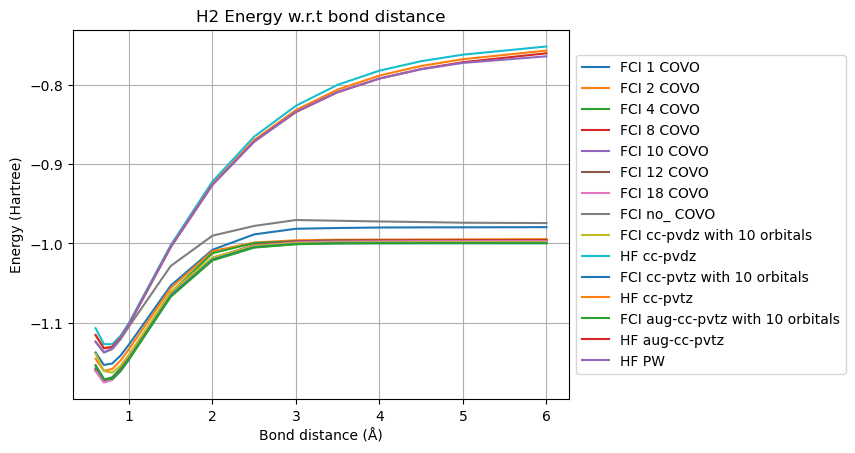

In [22]:
import matplotlib.pyplot as plt

energies_uccsd_pvdz_H2 = [result['energy uccsd'] for result in loaded_pvdz_H2]   
energies_fci_pvdz_H2 = [result['energy fci'] for result in loaded_pvdz_H2] 
energies_hf_pvdz_H2 = [result['energy Hartree-Fock'] for result in loaded_pvdz_H2] 
energies_uccsd_pvtz_H2 = [result['energy uccsd'] for result in loaded_pvtz_H2]   
energies_fci_pvtz_H2 = [result['energy fci'] for result in loaded_pvtz_H2] 
energies_hf_pvtz_H2 = [result['energy Hartree-Fock'] for result in loaded_pvtz_H2] 
energies_uccsd_augpvtz_H2 = [result['energy uccsd'] for result in loaded_augpvtz_H2]   
energies_fci_augpvtz_H2 = [result['energy fci'] for result in loaded_augpvtz_H2] 
energies_hf_augpvtz_H2 = [result['energy Hartree-Fock'] for result in loaded_augpvtz_H2] 

for covo in energies_covo_H2:
   # plt.plot(energies_covo_H2[covo][0], energies_covo_H2[covo][1], 'x-', label=f'UCCSD {covo} COVO')
    plt.plot(energies_covo_H2[covo][0], energies_covo_H2[covo][1], label=f'FCI {covo} COVO')
#plt.plot(energies_covo_H2[covo][0],energies_uccsd_pvdz_H2, label='UCCSD cc-pvdz with 10 orbitals')
plt.plot(energies_covo_H2[covo][0],energies_fci_pvdz_H2, label='FCI cc-pvdz with 10 orbitals')
plt.plot(energies_covo_H2[covo][0],energies_hf_pvdz_H2, label='HF cc-pvdz')
plt.plot(energies_covo_H2[covo][0],energies_fci_pvtz_H2, label='FCI cc-pvtz with 10 orbitals')
plt.plot(energies_covo_H2[covo][0],energies_hf_pvtz_H2, label='HF cc-pvtz')
plt.plot(energies_covo_H2[covo][0],energies_fci_augpvtz_H2, label='FCI aug-cc-pvtz with 10 orbitals')
plt.plot(energies_covo_H2[covo][0],energies_hf_augpvtz_H2, label='HF aug-cc-pvtz')
plt.plot(energies_covo_H2[covo][0],energias, label='HF PW')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Bond distance (Å)')
plt.grid(True)
plt.ylabel('Energy (Hartree)')
plt.title('H2 Energy w.r.t bond distance')
#plt.ylim([-1.18,-0.8])
#plt.savefig('H2_COVO.png')
plt.show()


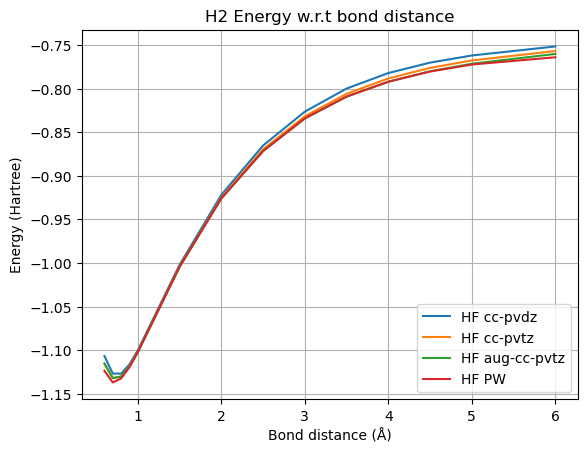

In [17]:
plt.plot(energies_covo_H2[covo][0],energies_hf_pvdz_H2, label='HF cc-pvdz')
plt.plot(energies_covo_H2[covo][0],energies_hf_pvtz_H2, label='HF cc-pvtz')
plt.plot(energies_covo_H2[covo][0],energies_hf_augpvtz_H2, label='HF aug-cc-pvtz')
plt.plot(energies_covo_H2[covo][0],energias, label='HF PW')
plt.legend(loc=4)
plt.xlabel('Bond distance (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('H2 Energy w.r.t bond distance')
plt.grid(True)
#plt.ylim([-1.18,-0.8])
plt.savefig('H2_HF.png')
plt.show()

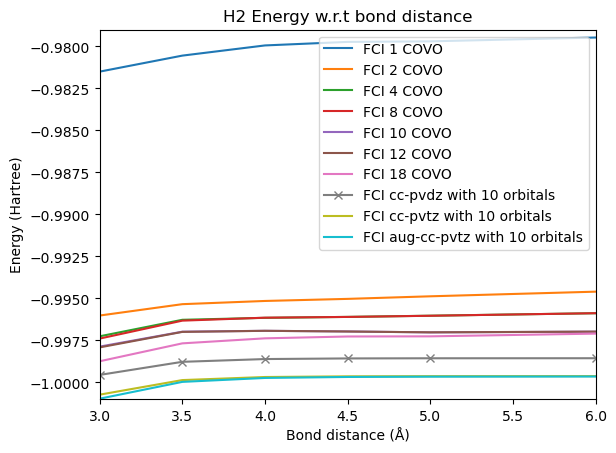

In [18]:
for covo in energies_covo_H2:
    #plt.plot(energies_covo_H2[covo][0], energies_covo_H2[covo][1], 'x-', label=f'UCCSD {covo} COVO')
    plt.plot(energies_covo_H2[covo][0], energies_covo_H2[covo][1], label=f'FCI {covo} COVO')
#plt.plot(energies_covo_H2[covo][0],energies_uccsd_pvdz_H2, 'o-', label='UCCSD cc-pvdz with 10 orbitals')
plt.plot(energies_covo_H2[covo][0],energies_fci_pvdz_H2, 'x-', label='FCI cc-pvdz with 10 orbitals')
plt.plot(energies_covo_H2[covo][0],energies_fci_pvtz_H2, label='FCI cc-pvtz with 10 orbitals')
plt.plot(energies_covo_H2[covo][0],energies_fci_augpvtz_H2, label='FCI aug-cc-pvtz with 10 orbitals')
plt.legend(loc=1)
plt.xlabel('Bond distance (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('H2 Energy w.r.t bond distance')
plt.ylim([-1.001,-0.979])
plt.xlim([3.0,6.0])
plt.savefig('H2_COVO.png')
plt.show()

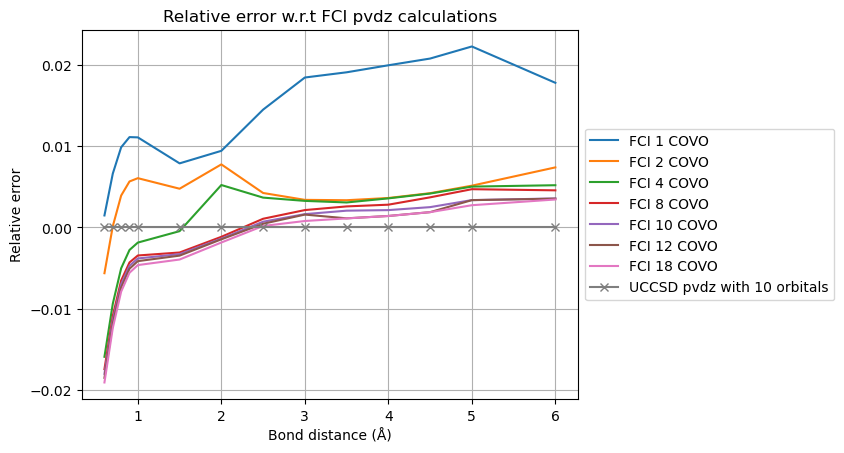

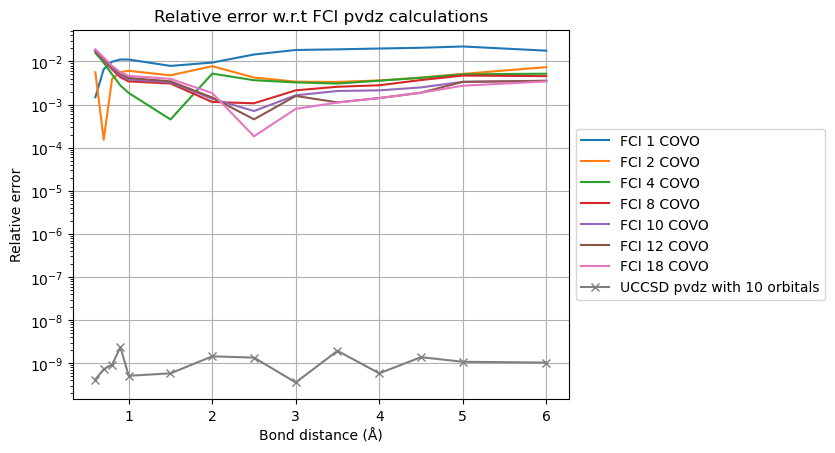

In [47]:
errors_uccsd_H2 = {}
errors_fci_H2 = {}

energies_fci_pvdz_H2 = np.array(energies_fci_pvdz_H2)
energies_uccsd_pvdz_H2 = np.array(energies_uccsd_pvdz_H2)


for covo in energies_covo_H2:
    errors_uccsd_H2[covo] =(energies_covo_H2[covo][1] - energies_fci_pvdz_H2)/np.abs(energies_fci_pvdz_H2)
    errors_fci_H2[covo] = (energies_covo_H2[covo][2] - energies_fci_pvdz_H2)/np.abs(energies_fci_pvdz_H2)

error_pvdz_uccsd_H2 = (energies_uccsd_pvdz_H2 - energies_fci_pvdz_H2)/np.abs(energies_fci_pvdz_H2)

for covo in errors_fci_H2:
    #plt.plot(energies_covo_H2[covo][0], errors_uccsd_H2[covo], 'o-', label=f'UCCSD {covo} COVO')  
    plt.plot(energies_covo_H2[covo][0], errors_fci_H2[covo],  label=f'FCI {covo} COVO')  

plt.plot(energies_covo_H2[covo][0], error_pvdz_uccsd_H2, 'x-', label = 'UCCSD pvdz with 10 orbitals')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.xlabel('Bond distance (Å)')
plt.ylabel('Relative error')
plt.title('Relative error w.r.t FCI pvdz calculations')
plt.savefig('error_covo.png')
plt.show()

for covo in errors_fci_H2:
    #plt.semilogy(energies_covo_H2[covo][0], errors_uccsd_H2[covo], 'o-', label=f'UCCSD {covo} COVO')  
    plt.semilogy(energies_covo_H2[covo][0], np.abs(errors_fci_H2[covo]),  label=f'FCI {covo} COVO')  

plt.semilogy(energies_covo_H2[covo][0], np.abs(error_pvdz_uccsd_H2), 'x-', label = 'UCCSD pvdz with 10 orbitals')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.xlabel('Bond distance (Å)')
plt.ylabel('Relative error')
plt.title('Relative error w.r.t FCI pvdz calculations')
plt.savefig('error_covo_log.png')
plt.show()

{'1': array([1.94073759e-11, 4.09020524e-07, 1.24029813e-07, 1.44282909e-08,
       7.32678245e-12, 3.31644464e-13, 1.82402062e-08, 1.14640552e-10,
       4.91475874e-09, 1.56918229e-03, 1.78012802e-03, 1.46487163e-03,
       1.24938285e-04, 6.54176609e-09]), '2': array([1.12670091e-07, 1.66317308e-07, 1.55290896e-08, 2.16427226e-07,
       1.50360439e-07, 9.87233071e-08, 3.37849928e-07, 1.32277455e-08,
       4.14396206e-07, 2.51099226e-07, 2.36070796e-07, 1.66184208e-07,
       2.63094166e-07, 8.37999896e-08]), '4': array([2.13354089e-13, 3.03564926e-13, 1.44977929e-13, 2.13573118e-07,
       1.97606276e-07, 5.23950371e-08, 2.49984281e-07, 7.99198767e-09,
       1.84676530e-08, 2.64737572e-07, 1.28579585e-07, 6.31759356e-08,
       1.37955665e-07, 2.96484537e-08]), '8': array([3.08850621e-08, 6.50103353e-09, 3.40724870e-08, 4.67248769e-07,
       2.72984216e-07, 4.36467022e-08, 6.88786404e-08, 1.09632299e-07,
       1.07834600e-07, 5.63738674e-08, 2.81870539e-07, 7.23921436e-08,
    

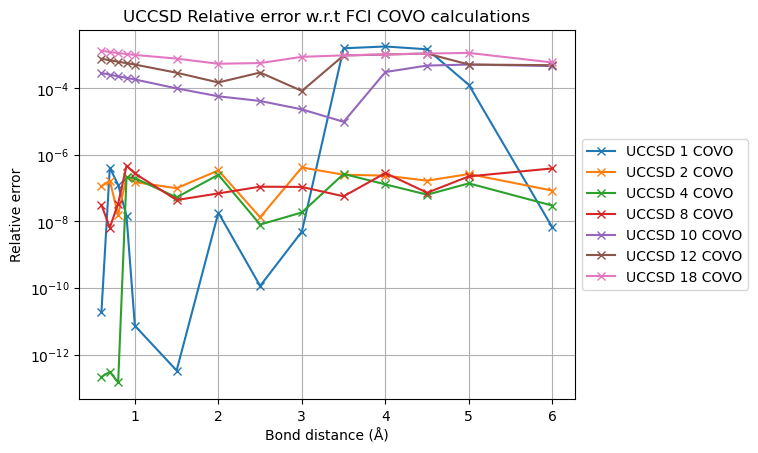

In [38]:
error_covos = {}

for covo in energies_covo_H2:
    
    energy_covo_uccsd = np.array(energies_covo_H2[covo][1])
    energy_covo_fci = np.array(energies_covo_H2[covo][2])
    
    error_covos[covo] = np.abs(energy_covo_uccsd - energy_covo_fci)/np.abs(energy_covo_fci)
    
print(error_covos)
for covo in energies_covo_H2:
    plt.semilogy(energies_covo_H2[covo][0], error_covos[covo], 'x-', label = f'UCCSD {covo} COVO')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.xlabel('Bond distance (Å)')
plt.ylabel('Relative error')
plt.title('UCCSD Relative error w.r.t FCI COVO calculations')
plt.savefig('error_covo_uccsd.png')
plt.show()